# Clustering locations of traffic cameras in Hong Kong using Amazon SageMaker and k-means

In [34]:
bucket_name = 'traffic-cameras-k-means'

In [146]:
import pandas as pd

cameras = pd.read_csv('Traffic_Camera_Locations_En.csv')
cameras.head()

,key,region,description,easting,northing,latitude,longitude,url
0,H429F,Hong Kong Island,Aberdeen Praya Road near Fish Market,833514,812196,22.248525,114.150158,http://tdcctv.data.one.gov.hk/H429F.JPG
1,H210F,Hong Kong Island,Aberdeen Tunnel - Wan Chai Side,836504,815117,22.274906,114.179164,http://tdcctv.data.one.gov.hk/H210F.JPG
2,H421F,Hong Kong Island,Aberdeen Tunnel - Aberdeen Side,836245,812386,22.250244,114.176651,http://tdcctv.data.one.gov.hk/H421F.JPG
3,H422F2,Hong Kong Island,Ap Lei Chau Bridge Road near Aberdeen Police S...,834632,812129,22.247922,114.161003,http://tdcctv.data.one.gov.hk/H422F2.JPG
4,H904F,Hong Kong Island,Canal Road Flyover near Gloucester Road,836731,815614,22.279394,114.181367,http://tdcctv.data.one.gov.hk/H904F.JPG


In [147]:
cameras.count()

key            210
region         210
description    210
easting        210
northing       210
latitude       210
longitude      210
url            210
dtype: int64

In [20]:
cameras.groupby('region').count()

,key,description,easting,northing,latitude,longitude,url,geometry
region,,,,,,,,
Hong Kong Island,34,34,34,34,34,34,34,34
Kowloon,58,58,58,58,58,58,58,58
Lantau,16,16,16,16,16,16,16,16
Shatin & Ma On Shan,24,24,24,24,24,24,24,24
"Tai Po, North & Yuen Long",31,31,31,31,31,31,31,31
Tsuen Wan,18,18,18,18,18,18,18,18
Tuen Mun & Tin Shui Wai,29,29,29,29,29,29,29,29


In [50]:
!pip install --upgrade pip --quiet
!pip install geopandas --quiet
!pip install descartes --quiet
!pip install mxnet --quiet

In [25]:
from geopandas import GeoDataFrame, points_from_xy

cameras_geo = GeoDataFrame(cameras, geometry=points_from_xy(cameras.longitude, cameras.latitude))
cameras_geo.head()

,key,region,description,easting,northing,latitude,longitude,url,geometry
0,H429F,Hong Kong Island,Aberdeen Praya Road near Fish Market,833514,812196,22.248525,114.150158,http://tdcctv.data.one.gov.hk/H429F.JPG,POINT (114.1501576 22.2485255)
1,H210F,Hong Kong Island,Aberdeen Tunnel - Wan Chai Side,836504,815117,22.274906,114.179164,http://tdcctv.data.one.gov.hk/H210F.JPG,POINT (114.1791642 22.27490622)
2,H421F,Hong Kong Island,Aberdeen Tunnel - Aberdeen Side,836245,812386,22.250244,114.176651,http://tdcctv.data.one.gov.hk/H421F.JPG,POINT (114.1766512 22.25024351)
3,H422F2,Hong Kong Island,Ap Lei Chau Bridge Road near Aberdeen Police S...,834632,812129,22.247922,114.161003,http://tdcctv.data.one.gov.hk/H422F2.JPG,POINT (114.1610034 22.24792186)
4,H904F,Hong Kong Island,Canal Road Flyover near Gloucester Road,836731,815614,22.279394,114.181367,http://tdcctv.data.one.gov.hk/H904F.JPG,POINT (114.1813669 22.2793944)


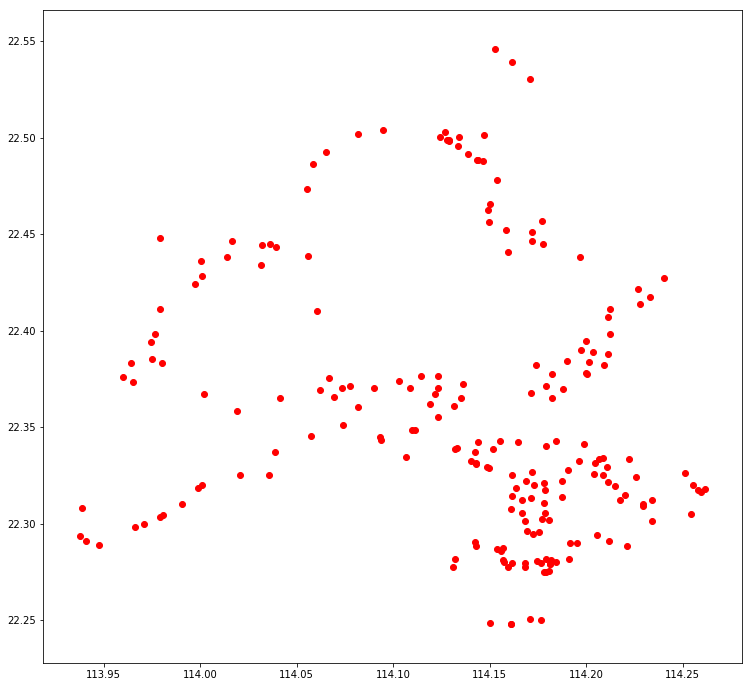

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [19, 12]

cameras_geo.plot(color='red')

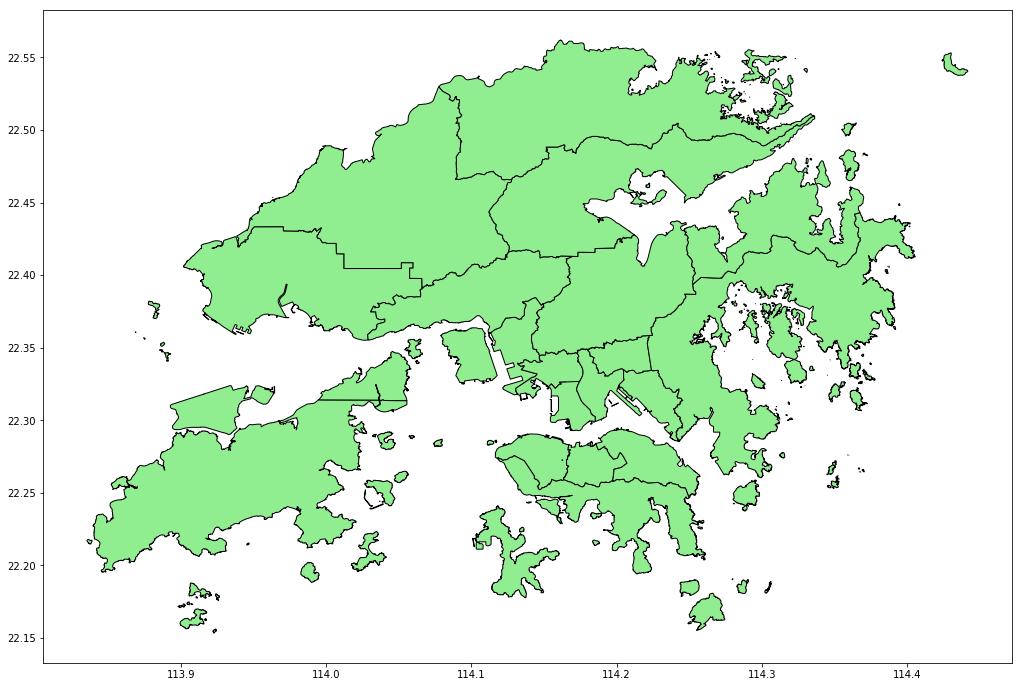

In [27]:
hong_kong = GeoDataFrame.from_file('Hong_Kong_18_Districts/')
hong_kong.plot(color='lightgreen', edgecolor='black')

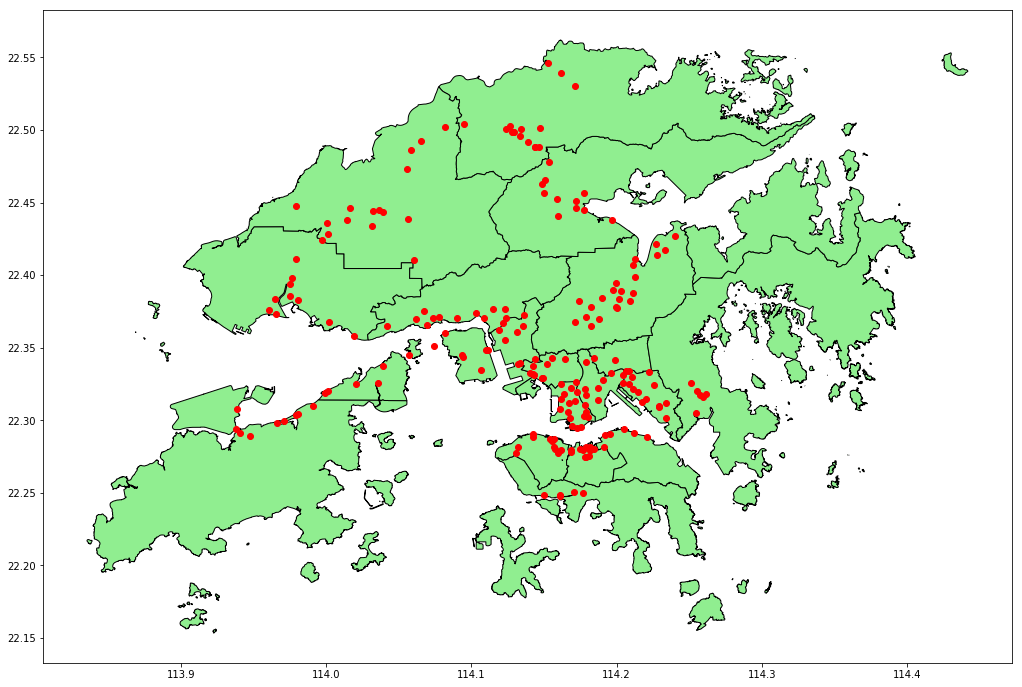

In [28]:
axes = hong_kong.plot(color='lightgreen', edgecolor='black')
cameras_geo.plot(ax=axes, color='red')

In [29]:
cameras.dtypes

key             object
region          object
description     object
easting          int64
northing         int64
latitude       float64
longitude      float64
url             object
geometry        object
dtype: object

In [30]:
from sagemaker import KMeans, get_execution_role

In [148]:
kmeans = KMeans(role=get_execution_role(),
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://' + bucket_name + '/',
                k=14)

In [149]:
train_df = cameras[['latitude', 'longitude']]
train_df.head()

,latitude,longitude
0,22.248525,114.150158
1,22.274906,114.179164
2,22.250244,114.176651
3,22.247922,114.161003
4,22.279394,114.181367


In [150]:
train_data = train_df.values.astype('float32')
train_data

array([[ 22.248526, 114.150154],
       [ 22.274906, 114.17916 ],
       [ 22.250244, 114.17665 ],
       [ 22.247921, 114.161   ],
       [ 22.279394, 114.181366],
       [ 22.279305, 114.181404],
       [ 22.281752, 114.19122 ],
       [ 22.285967, 114.15575 ],
       [ 22.286888, 114.15399 ],
       [ 22.277687, 114.159645],
       [ 22.281282, 114.18192 ],
       [ 22.28054 , 114.174446],
       [ 22.27971 , 114.176544],
       [ 22.281607, 114.179085],
       [ 22.27982 , 114.16856 ],
       [ 22.277832, 114.1685  ],
       [ 22.291067, 114.21197 ],
       [ 22.294012, 114.20541 ],
       [ 22.288265, 114.221146],
       [ 22.29022 , 114.195274],
       [ 22.275738, 114.180855],
       [ 22.281425, 114.15707 ],
       [ 22.28179 , 114.13231 ],
       [ 22.277582, 114.130875],
       [ 22.279827, 114.16167 ],
       [ 22.280369, 114.15765 ],
       [ 22.275042, 114.17837 ],
       [ 22.248283, 114.1611  ],
       [ 22.250559, 114.17069 ],
       [ 22.280117, 114.184616],
       [ 2

In [151]:
from datetime import datetime

job_name = 'traffic-cameras-k-means-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

In [152]:
%%time
kmeans.fit(kmeans.record_set(train_data), job_name=job_name)

2019-08-17 09:10:00 Starting - Starting the training job...
2019-08-17 09:10:03 Starting - Launching requested ML instances......
2019-08-17 09:11:10 Starting - Preparing the instances for training......
2019-08-17 09:12:24 Downloading - Downloading input data...
2019-08-17 09:12:59 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[08/17/2019 09:13:02 INFO 139808014489408] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]

In [153]:
import boto3

model_key = job_name + '/output/model.tar.gz'
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

In [154]:
import os

os.system('tar -zxvf model.tar.gz')

0

In [155]:
os.system('unzip model_algo-1')

2304

In [156]:
import mxnet as mx

Kmeans_model_params = mx.ndarray.load('model_algo-1')
Kmeans_model_params

[
 [[ 22.53749  114.16299 ]
  [ 22.3572   114.11168 ]
  [ 22.282722 114.16802 ]
  [ 22.382008 113.97388 ]
  [ 22.37851  114.1879  ]
  [ 22.498339 114.13076 ]
  [ 22.435738 114.01793 ]
  [ 22.319471 114.2208  ]
  [ 22.30703  113.976494]
  [ 22.32903  114.160126]
  [ 22.48855  114.06325 ]
  [ 22.455841 114.159454]
  [ 22.419    114.21927 ]
  [ 22.357122 114.05486 ]]
 <NDArray 14x2 @cpu(0)>]

In [157]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = train_df.columns

In [158]:
cluster_centroids

,latitude,longitude
0,22.537491,114.162987
1,22.357201,114.111679
2,22.282722,114.168022
3,22.382008,113.973877
4,22.378510,114.187897
5,22.498339,114.130760
6,22.435738,114.017929
7,22.319471,114.220802
8,22.307030,113.976494
9,22.329029,114.160126


In [159]:
centroids_geo = GeoDataFrame(
    cluster_centroids, geometry=points_from_xy(cluster_centroids.longitude, cluster_centroids.latitude))

In [160]:
centroids_geo

,latitude,longitude,geometry
0,22.537491,114.162987,POINT (114.1629867553711 22.53749084472656)
1,22.357201,114.111679,POINT (114.1116790771484 22.35720062255859)
2,22.282722,114.168022,POINT (114.1680221557617 22.28272247314453)
3,22.382008,113.973877,POINT (113.973876953125 22.38200759887695)
4,22.378510,114.187897,POINT (114.1878967285156 22.37850952148438)
5,22.498339,114.130760,POINT (114.1307601928711 22.49833869934082)
6,22.435738,114.017929,POINT (114.0179290771484 22.43573760986328)
7,22.319471,114.220802,POINT (114.2208023071289 22.31947135925293)
8,22.307030,113.976494,POINT (113.9764938354492 22.30702972412109)
9,22.329029,114.160126,POINT (114.1601257324219 22.32902908325195)


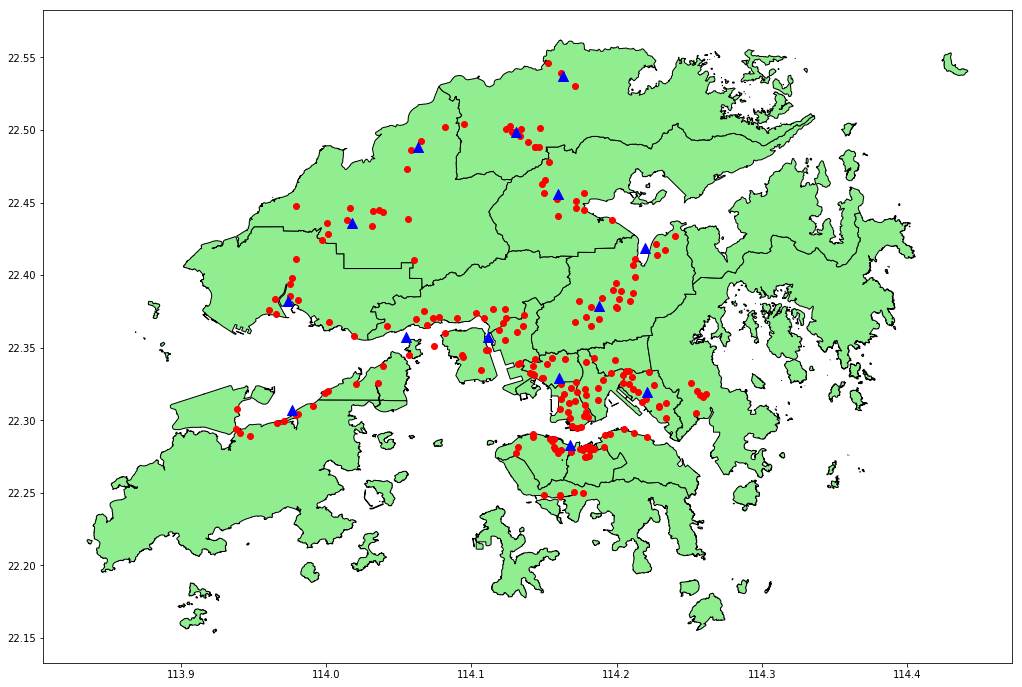

In [161]:
axes = hong_kong.plot(color='lightgreen', edgecolor='black')
cameras_geo.plot(ax=axes, color='red')
centroids_geo.plot(ax=axes, marker='^', color='blue', markersize=100)